In [2]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD.readers import *
from MDPD import utils, MDPD
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [5]:
# folder = '/media/vzhao/Data/crowdsourcing_datasets/'
folder = '/Users/vincent/Documents/Research/MDPD/crowdsourcing_datasets'

In [6]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'bird', 'bluebird_crowd.txt'), os.path.join(folder, 'bird', 'bluebird_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:], dtype=np.bool)
print train.shape

(108, 39, 2)


In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'dog', 'dog_crowd.txt'), os.path.join(folder, 'dog', 'dog_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'rte', 'rte_crowd.txt'), os.path.join(folder, 'rte', 'rte_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'trec', 'trec_crowd.txt'), os.path.join(folder, 'trec', 'trec_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'web', 'web_crowd.txt'), os.path.join(folder, 'web', 'web_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

#### Update global variables

In [7]:
NSAMPLE, DIM, NVOCAB = train.shape
EFF_NVOCAB = NVOCAB-1 if reader.is_missing_value else NVOCAB

---
## Analysis

## Original Mutual Information Residue

In [8]:
%%time
# Original mutual information residue (G score)
score_origin = utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
sigma_origin = score_origin.sum(axis=1)
print np.sum(score_origin) / (DIM * (DIM-1))

0.0375625382987
CPU times: user 3.49 ms, sys: 1.85 ms, total: 5.34 ms
Wall time: 4.46 ms


MDPD/utils.py:228: RuntimeWarning: divide by zero encountered in log
  log_second = np.log(second)
MDPD/utils.py:229: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (log_second - log_first)


#### Reference G Statistics

In [9]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100., (EFF_NVOCAB**2 - 1)) / (2 * NSAMPLE) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.052522531158075793, 0.036179295848385078, 0.028941614033195937, 0.019020115442742205, 0.01095358279803397]


## Mutual Information Residue if use the true label as the posterior distribution

In [10]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,label.max()+1)
utils.log_replace_neginf(log_post)

/Users/vincent/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [11]:
%%time
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.0225729616298
CPU times: user 6.86 ms, sys: 1.71 ms, total: 8.57 ms
Wall time: 7.3 ms


#### [Plot] Mutual Information Residue if use the true label as the posterior distribution vs. Raw Residue

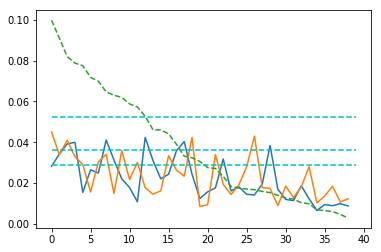

In [12]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

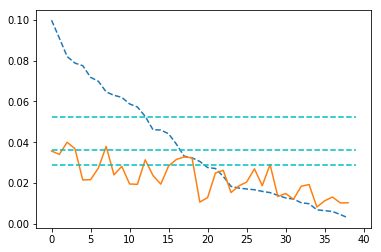

In [13]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Mixture Model with Feature Selection Performance

#### Feature Ranking

In [14]:
%%time
features, sigma = utils.Feature_Selection.MI_feature_ranking(train, lock=lock)
print features

[16  7 29 34 26 24  0 31 11  8 36 37 15 19 28 21 18 38  4 14 20  2 23 35  1
 30 13 32 27 22 12  9 25 33  6 17  3 10  5]
CPU times: user 3.59 ms, sys: 1.52 ms, total: 5.11 ms
Wall time: 3.83 ms


#### Accuracy and Mutual Information Residue

In [15]:
Ntop = 15

In [16]:
# Feature Selection
model = MDPD.MDPD_standard()
model.fit(train, ncomp=5, init='majority', verbose=False, features=features[:Ntop], epoch=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train)

2018-04-07 23:10:38,285 : INFO : Training an MDPD with dimension 39, 15 features, sample size 108, vocab size 2 and the target number of components 5
MDPD/utils.py:92: RuntimeWarning: divide by zero encountered in log
  log_votes = np.log(votes)
2018-04-07 23:10:38,415 : INFO : ACCURACY: 91.67%
2018-04-07 23:10:38,423 : INFO : The mutual information residue (include all features) is 0.014768358283
2018-04-07 23:10:38,425 : INFO : The mutual information residue (within selected features) is 0.0174441723022


In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
log_post = model.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue of the model with feature selection'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(score_condition[idx, :] * weights[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Vanilla Model Performance
#### Accuracy and Mutual Information Residue

In [ ]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD()
model_basic.fit(train, ncomp=EFF_NVOCAB, init='majority', verbose=False, epoch=50, lock=lock)
model_basic.accuracy(train, label)
model_basic.MI_residue(train)

In [ ]:
log_post = model_basic.log_posterior(train)
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

print 'Mutual Information Residue (within the selected features)'
score_select = score[features[:Ntop, np.newaxis], features[:Ntop], :]
res_select = np.sum(score_select.sum(axis=1) * weights[np.newaxis, :]) / (Ntop * (Ntop - 1))
print res_select

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()